# 👉 What is PyCaret?

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive.

In comparison with the other open-source machine learning libraries, PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with few words only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and many more.

The design and simplicity of PyCaret is inspired by the emerging role of citizen data scientists, a term first used by Gartner. Citizen Data Scientists are power users who can perform both simple and moderately sophisticated analytical tasks that would previously have required more expertise. Seasoned data scientists are often difficult to find and expensive to hire but citizen data scientists can be an effective way to mitigate this gap and address data-related challenges in the business setting.

Official Website: https://www.pycaret.org
Documentation: https://pycaret.readthedocs.io/en/latest/

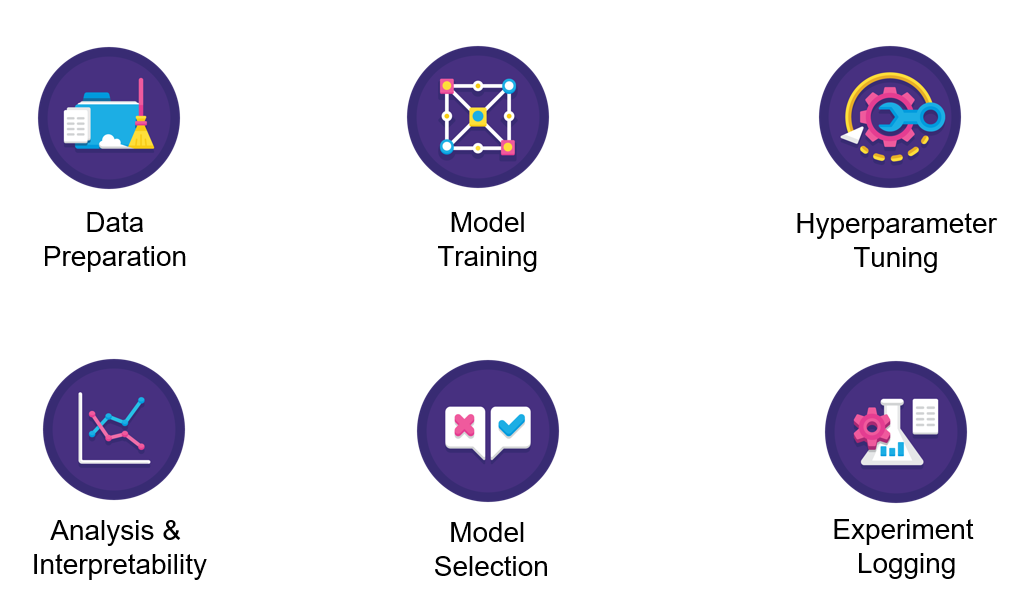

# 👉 Install PyCaret
Installing PyCaret is very easy and takes only a few minutes. We strongly recommend using a virtual environment to avoid potential conflicts with other libraries. PyCaret's default installation is a slim version of pycaret that only installs hard dependencies that are listed in [requirements.txt](https://github.com/pycaret/pycaret/blob/master/requirements.txt). To install the default version:

- `pip install pycaret`

When you install the full version of pycaret, all the optional dependencies as listed [here](https://github.com/pycaret/pycaret/blob/master/requirements-optional.txt) are also installed.To install version:

- `pip install pycaret[full]`

# 👉Dataset

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('AirPassengers.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.head()

Date  Passengers
0 1949-01-01         112
1 1949-02-01         118
2 1949-03-01         132
3 1949-04-01         129
4 1949-05-01         121

In [2]:
import plotly.express as px
data['MA12'] = data['Passengers'].rolling(12).mean()
fig = px.line(data, x="Date", y=["Passengers", "MA12"], template = 'plotly_dark')
fig.show()

# 👉 Data Preparation

In [3]:
# extract features from date
data['Month'] = [i.month for i in data['Date']]
data['Year'] = [i.year for i in data['Date']]
data['Series'] = np.arange(1,len(data)+1).astype('int64')

# drop date and MA12
data.drop(['Date', 'MA12'], axis=1, inplace=True)

# rearrange columns
data = data[['Series', 'Year', 'Month', 'Passengers']] #re-arrange columns

# check head
data.head()

Series  Year  Month  Passengers
0       1  1949      1         112
1       2  1949      2         118
2       3  1949      3         132
3       4  1949      4         129
4       5  1949      5         121

In [4]:
train = data[data['Year'] < 1960]
test = data[data['Year'] >= 1960]
train.shape, test.shape

((132, 4), (12, 4))

In [5]:
from pycaret.regression import *

s = setup(data = train, test_data = test,
          target = 'Passengers', 
          fold_strategy = 'timeseries',
          numeric_features = ['Year', 'Series'],
          fold = 3,
          transform_target = True,
          session_id = 123, silent = True,
          log_experiment = True, experiment_name = 'airpassengers', log_plots=True, log_data=True)

2021/06/14 10:55:23 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: No module named 'repository'


In [6]:
# check X_train index
get_config('X_train').index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            122, 123, 124, 125, 126, 127, 128, 129, 130, 131],
           dtype='int64', length=132)

In [7]:
# check X_test index
get_config('X_test').index

Int64Index([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143], dtype='int64')

# 👉Model Training & Selection

## Compare Models

In [8]:
# train all models using default hyperparameters
best = compare_models(sort = 'MAE')

In [9]:
print(best)

PowerTransformedTargetRegressor(copy_X=True, eps=2.220446049250313e-16,
                                fit_intercept=True, fit_path=True, jitter=None,
                                n_nonzero_coefs=500, normalize=True,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=Lars(copy_X=True,
                                               eps=2.220446049250313e-16,
                                               fit_intercept=True,
                                               fit_path=True, jitter=None,
                                               n_nonzero_coefs=500,
                                               normalize=True,
                                               precompute='auto',
                                               random_state=123,
                                    

In [10]:
# check on hold-out
pred_holdout = predict_model(best);

In [11]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Plot Actual and Predicted values

In [12]:
predictions = predict_model(best, data=data)
predictions['Date'] = pd.date_range(start='1949-01-01', end = '1960-12-01', freq = 'MS')

import plotly.express as px
fig = px.line(predictions, x='Date', y=["Passengers", "Label"], template = 'plotly_dark')
fig.add_vrect(x0="1960-01-01", x1="1960-12-01", fillcolor="grey", opacity=0.25, line_width=0)

fig.show()

# Predict Future Values

In [13]:
# create future dataset to score
future_dates = pd.date_range(start = '1961-01-01', end = '1965-01-01', freq = 'MS')

future_df = pd.DataFrame()

future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates]    
future_df['Series'] = np.arange(145,(145+len(future_dates)))

future_df.head()

Month  Year  Series
0      1  1961     145
1      2  1961     146
2      3  1961     147
3      4  1961     148
4      5  1961     149

In [14]:
# finalize model
final_best = finalize_model(best)

In [15]:
# generate predictions on future dataset
predictions_future = predict_model(final_best, data=future_df)
predictions_future.head()

Month  Year  Series       Label
0      1  1961     145  486.278268
1      2  1961     146  482.208186
2      3  1961     147  550.485953
3      4  1961     148  535.187166
4      5  1961     149  538.923776

In [16]:
# plot historic and predicted values
concat_df = pd.concat([data,predictions_future], axis=0)
concat_df_i = pd.date_range(start='1949-01-01', end = '1965-01-01', freq = 'MS')
concat_df.set_index(concat_df_i, inplace=True)

import plotly.express as px
fig = px.line(concat_df, x=concat_df.index, y=["Passengers", "Label"], template = 'plotly_dark')
fig.show()

## THE END

In [17]:
# !mlflow ui